1.У вас, с прошлого урока, имеются реализации расчёта среднеквадратичной ошибки и её градиента для линейнй регрессии с коэффициентами при факторах(w) и свободным коэффициентам.

```python
def mserror(X, w, c0, y_real):
    y = X.dot(w.T)+c0
    return np.sum((y - y_real)**2) / y_real.shape[0]

def mserror_grad(X, w, c0, y_real):
    delta=(X.dot(w.T)+c0-y_real)
    return 2*delta.T.dot(X)/y_real.shape[0], np.sum(2*delta)/y_real.shape[0]
```

В этом задании вы должны модифицировать реализацию рассчёта среднеквадратичной ошибки и рассчёта её производной, так, чтобы с к среднеквадратичной ошибке добавлялась l2 регулярязационная поправка: $ +c*\sum \limits _{j}  w_{j}^2 $ а к градиенту- ссответствующее выражение для градиента регулярязационной поправки.

2.На основе этих функций создайте свою регуляризированную полиномиальную регрессию и опробуйте на одном из примеров построения полиномиальной модели из этого урока. <br>
<i><b>Пояснение:</b>Для этого Вам достаточно создать класс, который наследуется от класса polynomial_regression из данного урока, и переопределить в нём статические методы mserror, mserror_grad(под переопределением подразумевается создание на новом классе методов с таким же названием). Не забывайте использовать декоратор @staticmethod. Как уже было объяснено на вебинаре это приведет к тому что при вызове метода fit, будет вызываться его версия из текущего урока генерирующая полиномиальные фичи, и использующая их для вызова реализации из прошлого урока, которая для рассчёта градиента вызывает переопределяемый в этом задании метод mserror_grad, и таким образом с переопределением метода станет рассчитывать градиент по новому.</i>

In [27]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from linear_regression import linear_regression
from sklearn.linear_model import LinearRegression as sklearn_LR
%matplotlib inline

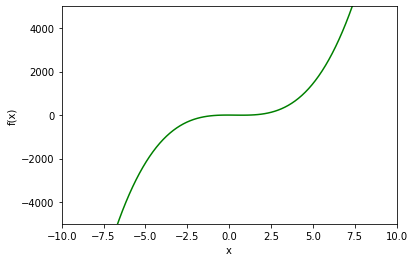

In [41]:
def f(x):
    return 0.5 - 3.2 * x - 15.3 * x ** 2 + 14.7 * x ** 3
dots = np.linspace(-10, 10, 100)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='g')

In [63]:
def f(x):
    return 0.5 - 3.2 * x - 15.3 * x ** 2 + 14.7 * x ** 3
np.random.seed(16)
x_data = np.random.uniform(-10, 10, 50)
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, 50)

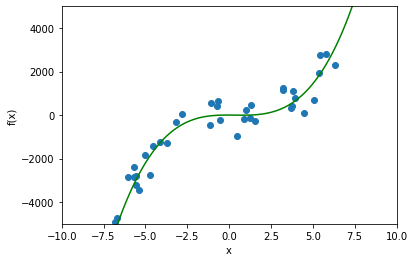

In [64]:
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

In [65]:
class polynomial_regression(linear_regression):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
        
    @staticmethod
    def mserror(X, w, c0, y_real, lam=1000):
        y = X.dot(w.T)+c0
        return np.sum((y - y_real)**2) / y_real.shape[0] +lam*(np.sum(w)**2)
    @staticmethod
    def mserror_grad(X, w, c0, y_real, lam=1000):
        delta=(X.dot(w.T)+c0-y_real)
        return 2*delta.T.dot(X)/y_real.shape[0]+2*lam*w, np.sum(2*delta)/y_real.shape[0]+2*lam*np.sum(w)
    @staticmethod
    def generate_features(x, max_power):
        x=x[:, np.newaxis]
        return np.concatenate([x**i for i in range(1, max_power+1)], axis=1)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y[:, np.newaxis])
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power)).flatten()
    def test(self, x, y):
        return super().test(self.generate_features(x, self.max_power), y[:, np.newaxis])
    
class polynomial_regression_sklearn(sklearn_LR):
    def __init__(self, max_power, *args, **kwargs):
        self.max_power=max_power
        super().__init__(*args, **kwargs)
    generate_features=staticmethod(polynomial_regression.generate_features)
    def fit(self, x, y):
        super().fit(self.generate_features(x, self.max_power), y)
    def predict(self, x):
        return super().predict(self.generate_features(x, self.max_power))

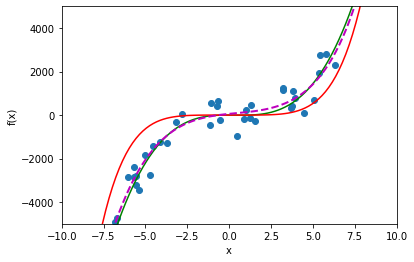

In [66]:
#Актуальные данные
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)
plt.plot(dots, f(dots), color='g')
plt.scatter(x_data, f_data)

#Наша модель
model1 = polynomial_regression(6, 0.0005, max_iter = 1e5)
model1.fit(x_data, f_data)
plt.plot(dots, model1.predict(dots), color='r')

#Sklearn
model2 = polynomial_regression_sklearn(6)
model2.fit(x_data, f_data)
plt.plot(dots, model2.predict(dots), 'm--', linewidth=2)

In [67]:
#Значение штрафной функции для нашей модели
linear_regression.mserror(polynomial_regression.generate_features(x_data, 6), 
                          model1.w, model1.c, f_data[:, np.newaxis])

1493365.8947127068

In [68]:
#Значение штрафной функции для модели Sklearn
linear_regression.mserror(polynomial_regression.generate_features(x_data, 6), 
                          model2.coef_[np.newaxis, :], model2.intercept_, f_data[:, np.newaxis])

307276.5703252483

3*. (по желанию). Оцените оцените предсказательную способность реализованного метода с использование 5-ти ступенчатой кросс-валидации, показанной в примере выше. 

In [69]:
#Посчитаем р-квадрат
def r_square(y, y_real):
    ss_total=np.sum((y_real-np.mean(y_real))**2)
    ss_res=np.sum((y_real-y)**2)
    return 1-ss_res/ss_total
print(r_square(model1.predict(x_data), f_data))

0.9442524091369626


In [70]:
# наша модель
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression(6, 0.0005, max_iter = 1e5)
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.9299442045573135


In [72]:
#Sklearn
indexes=np.arange(len(f_data))%5
y_actual=[]
y_predicted=[]

for i in range(5):
    y_actual.append(f_data[indexes==i])
    mod=polynomial_regression_sklearn(6)
    mod.fit(x_data[indexes!=i], f_data[indexes!=i])
    y_predicted.append(mod.predict(x_data[indexes==i]))
    
y_actual=np.concatenate(y_actual)
y_predicted=np.concatenate(y_predicted)
print(r_square(y_predicted, y_actual))

0.9799982466827564


Как видо из результатов $R^2$ наша модель хуже описывает те данные, нежели модель __Sklearn__

<b>Домашнее задание: </b> Модифицировать пример со стохастическим градиентом, реализовав в нём рассчёт градиента по десяти случайно выбираемым объектам (mini-batch градиент).  

In [94]:
from sklearn import datasets
import numpy as np
data, target, coef = datasets.make_regression(n_samples=1000, n_features = 2, n_informative = 2, 
                                              n_targets = 1, 
                                              noise = 5, coef = True, random_state = 2)

In [95]:
# Получим средние значения и стандартное отклонение по столбцам

means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
# параметр axis указывается для вычисления значений по столбцам, а не по всему массиву
#(см. документацию в разделе источников)

# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i][j] = (data[i][j] - means[j])/stds[j]

In [96]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(X, w, y_pred):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y)

In [109]:
# инициализируем начальный вектор весов
w = np.zeros(2)

# список векторов весов после каждой итерации
w_list = [w.copy()]

# список значений ошибок после каждой итерации
errors = []

# шаг градиентного спуска
eta = 0.02

# максимальное число итераций
max_iter = 1e5

# критерий сходимости (разница весов, при которой алгоритм останавливается)
min_weight_dist = 1e-8

# зададим начальную разницу весов большим числом
weight_dist = np.inf

# счетчик итераций
iter_num = 0

np.random.seed(1234)

# ход градиентного спуска
while weight_dist > min_weight_dist and iter_num < max_iter:
    
    #train_ind = np.random.randint(data.shape[0]) # генерируем случайный индекс объекта выборки
    train_ind = [np.random.randint(data.shape[0]) for i in range(10)] # генерируем 10 случайных индексов объекта выборки
    
    new_w = w - 2 * eta * np.dot(data[train_ind].T, (np.dot(data[train_ind], w) - target[train_ind])) / target.shape[0]

    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    w_list.append(new_w.copy())
    error=mserror(data, new_w, target)
    errors.append(error)
    if iter_num %1000==0:
        print(error)
    
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)

print(f'В случае использования стохастического градиентного спуска функционал ошибки составляет {round(errors[-1], 4)}')

8185.566989346223
3725.82274409257
1708.299433029031
782.1980475656896
373.2960676820801
191.0576018943803
107.64081111011801
69.9333907219096
52.86882729772499
45.177114101157024
41.61180220283013
39.93315175032331
39.18108548767099
38.85874905095948
38.70576338983833
38.62396205188399
38.60528995526542
38.58736576518207
38.57565285133656
38.5757867184892
38.57080265431338
38.56932050717641
38.568306659035734
38.56826296366456
38.570190600175295
38.57008486333181
38.570193056164655
38.56870158091625
38.57015652933008
38.56832301784319
38.570280417048956
38.57123622836968
38.57064715419557
38.56928858059275
38.570684309271705
38.56848014482205
38.56832176063105
38.56999911848131
38.570326161976915
38.5683670439693
38.570161900010156
38.56940861333358
38.56842127873448
38.568617385249
38.569613808812
38.570607013224546
38.57404889719943
38.571357372679984
38.5713291529811
38.56887643567702
38.56998960347806
38.56877571114836
38.56904339130065
38.56971420582215
38.56855662935435
38.56846